In [1]:
# Import libraries

import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, auc, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC

In [2]:
try:
    heart_dis_data = pd.read_excel('C:/Users/61450/Desktop/refonte folder/heart disease prediction/heart.xlsx')
except FileNotFoundError as e:
    print(f"Error: {e}")

In [3]:
try:
    if heart_dis_data.empty:
        print('data frame is empty')
    else:
        missing_values = heart_dis_data.isnull().sum()
        if missing_values.any() > 0:
            for column in heart_dis_data.columns:
                if heart_dis_data[column].dtype in ['int64', 'float64']:
                    heart_dis_data[column].fillna(heart_dis_data[column].median(), inplace=True)
                else:
                    heart_dis_data[column].fillna(heart_dis_data[column].mode(), inplace=True)
            
            heart_dis_data.dropna(axis=1, how='all')
        else:
            print('there are no missing values/columns')
            
except attributeerror as e:
    print(f"error:{e}")
    print("the data frame does not exist or is malformed")
    heart_dis_data = pd.DataFrame()

there are no missing values/columns


In [4]:
heart_dis_data.head()

,age,sex,Chest pain type,Blood pressure,cholestrol,fasting blood sugar,resting electrocardiogarphic results,maximum heart rate achieved,exercise induced angina,oldpeak,slope,number of major vessels coloured by fluoroscopy,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
heart_features = heart_dis_data[['sex','Chest pain type', 'fasting blood sugar','resting electrocardiogarphic results','exercise induced angina',
'slope','thalassemia','target']].astype('category')

heart_dis_data[['sex','Chest pain type', 'fasting blood sugar','resting electrocardiogarphic results','exercise induced angina',
'slope','thalassemia','target']]  = heart_features

heart_dis_data.dtypes

age                                                   int64
sex                                                category
Chest pain type                                    category
Blood pressure                                        int64
cholestrol                                            int64
fasting blood sugar                                category
resting electrocardiogarphic results               category
maximum heart rate achieved                           int64
exercise induced angina                            category
oldpeak                                             float64
slope                                              category
number of major vessels coloured by fluoroscopy       int64
thalassemia                                        category
target                                             category
dtype: object

<Axes: xlabel='exercise induced angina', ylabel='count'>

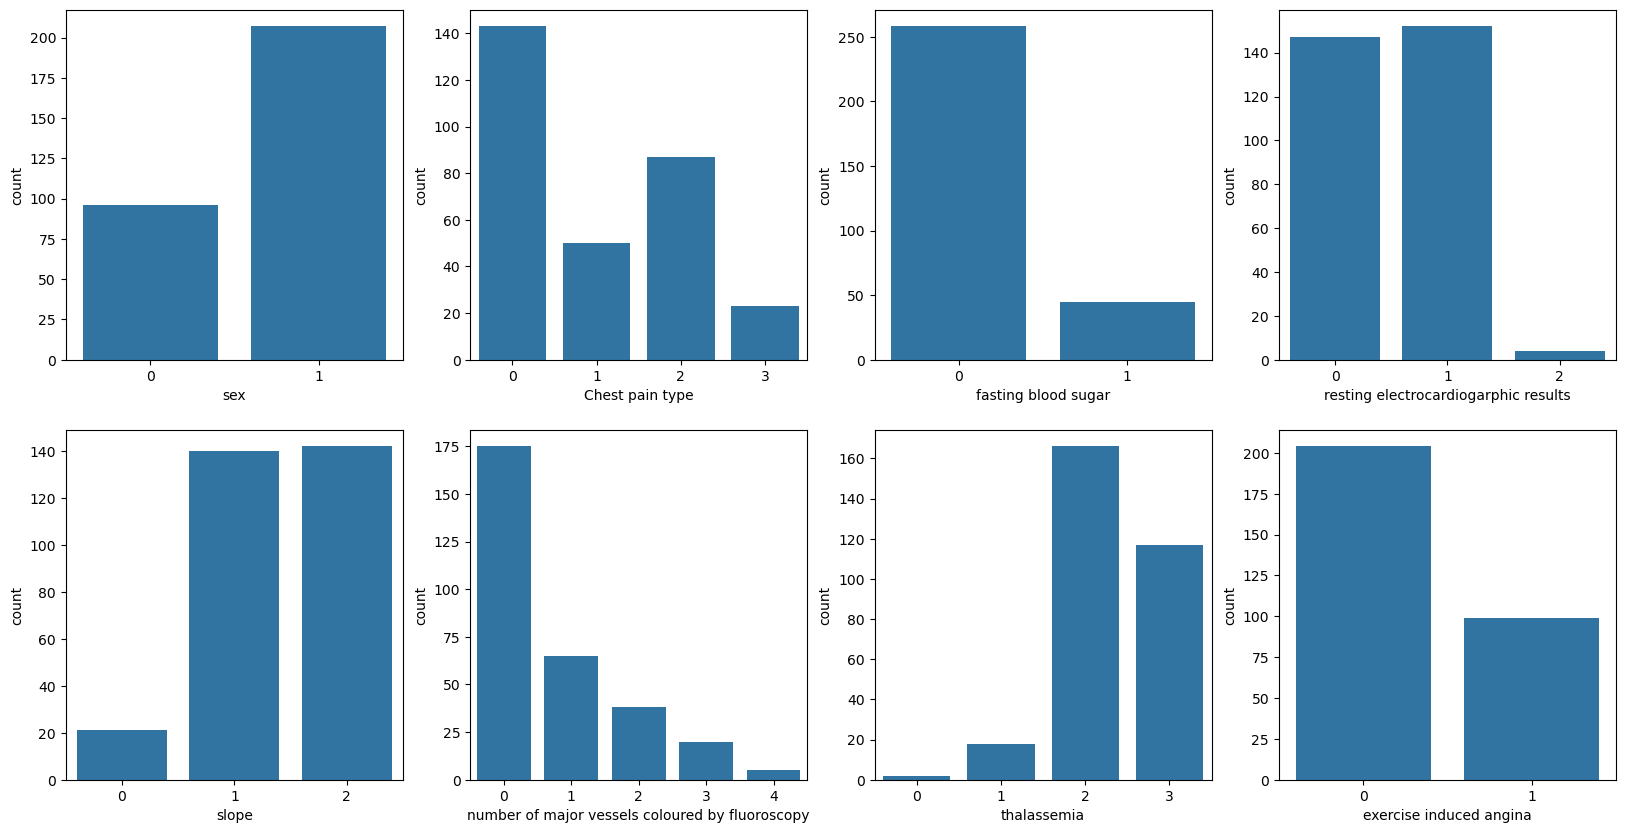

In [6]:
fig, axes = plt.subplots(2,4,figsize=(20,10))

sns.countplot(data=heart_dis_data, x='sex', ax=axes[0,0])
sns.countplot(data=heart_dis_data, x='Chest pain type', ax=axes[0,1])
sns.countplot(data=heart_dis_data, x='fasting blood sugar', ax=axes[0,2])
sns.countplot(data=heart_dis_data, x='resting electrocardiogarphic results', ax=axes[0,3])
sns.countplot(data=heart_dis_data, x='slope', ax=axes[1,0])
sns.countplot(data=heart_dis_data, x='number of major vessels coloured by fluoroscopy', ax=axes[1,1])
sns.countplot(data=heart_dis_data, x='thalassemia', ax=axes[1,2])
sns.countplot(data=heart_dis_data, x='exercise induced angina', ax=axes[1,3])

In [7]:
# Map the classes of categorical names into their distinctive class names

In [8]:
heart_dis_data['Chest pain type'] = heart_dis_data['Chest pain type'].map({0: 'typical angina', 1: 'atypical angina', 2:'non-anginal pain', 3:'asymptomatic'})
heart_dis_data['resting electrocardiogarphic results'] = heart_dis_data['resting electrocardiogarphic results'].map({1: 'ST-T wave abnormality', 0: 'normal', 2:'left ventricular hypertrophy'})
heart_dis_data['slope'] = heart_dis_data['slope'].map({1: 'flat', 0: 'upsloping', 2: 'downsloping'})
heart_dis_data['thalassemia'] = heart_dis_data['thalassemia'].map({1: 'fixed defect', 0: 'normal', 2: 'reversible defect', 3: 'not described'})

In [9]:
# One Hot encoding of categorical variables

In [10]:
one_hot = preprocessing.OneHotEncoder(sparse_output=False)

variables = ['Chest pain type','resting electrocardiogarphic results','slope','thalassemia']
new_columns = pd.DataFrame()

for v in variables:
    trans_var =  one_hot.fit_transform(np.array(heart_dis_data[v]).reshape(len(heart_dis_data[v]),1))
    var =  pd.DataFrame(trans_var, columns=sorted(list(heart_dis_data[v].unique())))
    new_columns = pd.concat([new_columns, var], axis=1)

In [11]:
heart_data = pd.concat([heart_dis_data, new_columns], axis=1)

In [12]:
heart_data = heart_data.drop(['Chest pain type','resting electrocardiogarphic results','slope','thalassemia'],axis=1)
heart_data = heart_data.rename(columns={'sex':'sex (male = 1)', 'fasting blood sugar':'blood sugar (high = 1)'})

In [13]:
heart_data.head()

,age,sex (male = 1),Blood pressure,cholestrol,blood sugar (high = 1),maximum heart rate achieved,exercise induced angina,oldpeak,number of major vessels coloured by fluoroscopy,target,...,ST-T wave abnormality,left ventricular hypertrophy,normal,downsloping,flat,upsloping,fixed defect,normal,not described,reversible defect
0,63,1,145,233,1,150,0,2.3,0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,37,1,130,250,0,187,0,3.5,0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,41,0,130,204,0,172,0,1.4,0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,56,1,120,236,0,178,0,0.8,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,57,0,120,354,0,163,1,0.6,0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# Exploratory Data analysis

Text(0, 0.5, 'Distribution of classes in target variable')

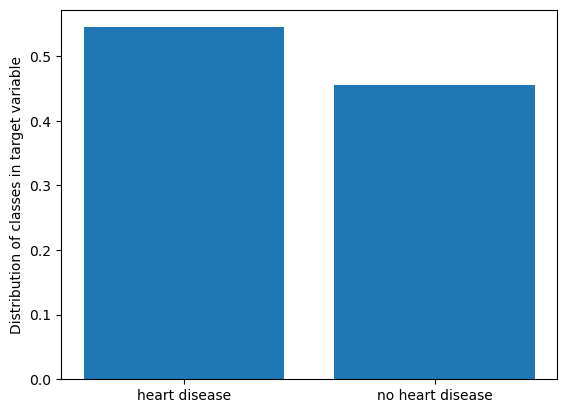

In [15]:
y = heart_data['target'].value_counts()/len(heart_data['target'])
x = ['heart disease','no heart disease']
plt.bar(x,y)
plt.ylabel('Distribution of classes in target variable')

In [16]:
# Descriptive statistics of quantitative variables

heart_data[['age','Blood pressure','cholestrol','maximum heart rate achieved','oldpeak','number of major vessels coloured by fluoroscopy']].describe()

,age,Blood pressure,cholestrol,maximum heart rate achieved,oldpeak,number of major vessels coloured by fluoroscopy
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604,0.729373
std,9.082101,17.538143,51.830751,22.905161,1.161075,1.022606
min,29.000000,94.000000,126.000000,71.000000,0.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000,0.000000
75%,61.000000,140.000000,274.500000,166.000000,1.600000,1.000000
max,77.000000,200.000000,564.000000,202.000000,6.200000,4.000000


Text(0.5, 0.98, 'distribution of quantitative variables')

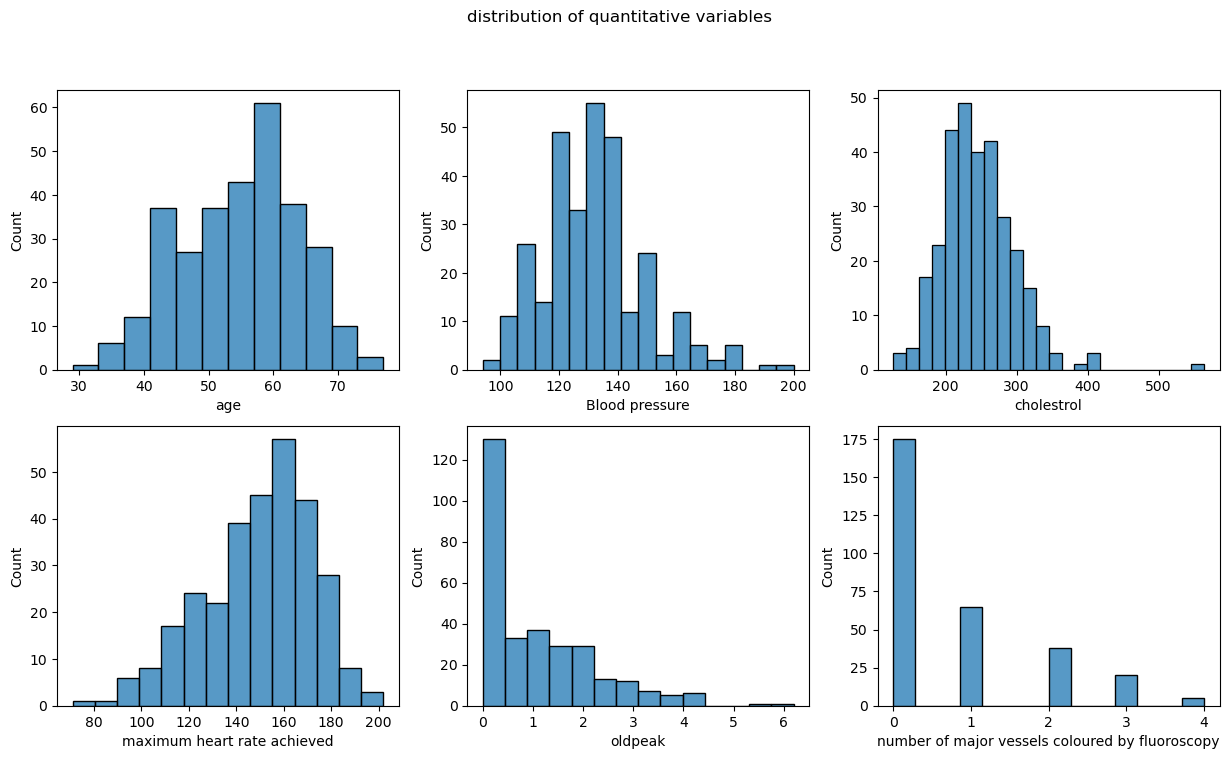

In [17]:
fig = plt.figure(figsize=(15,8))

c = ['age','Blood pressure','cholestrol','maximum heart rate achieved','oldpeak','number of major vessels coloured by fluoroscopy']

x = [231, 232, 233, 234, 235, 236]

for i in range(len(x)):
    ax = fig.add_subplot(x[i])
    sns.histplot(data=heart_data, x=c[i], ax=ax)

fig.suptitle('distribution of quantitative variables')

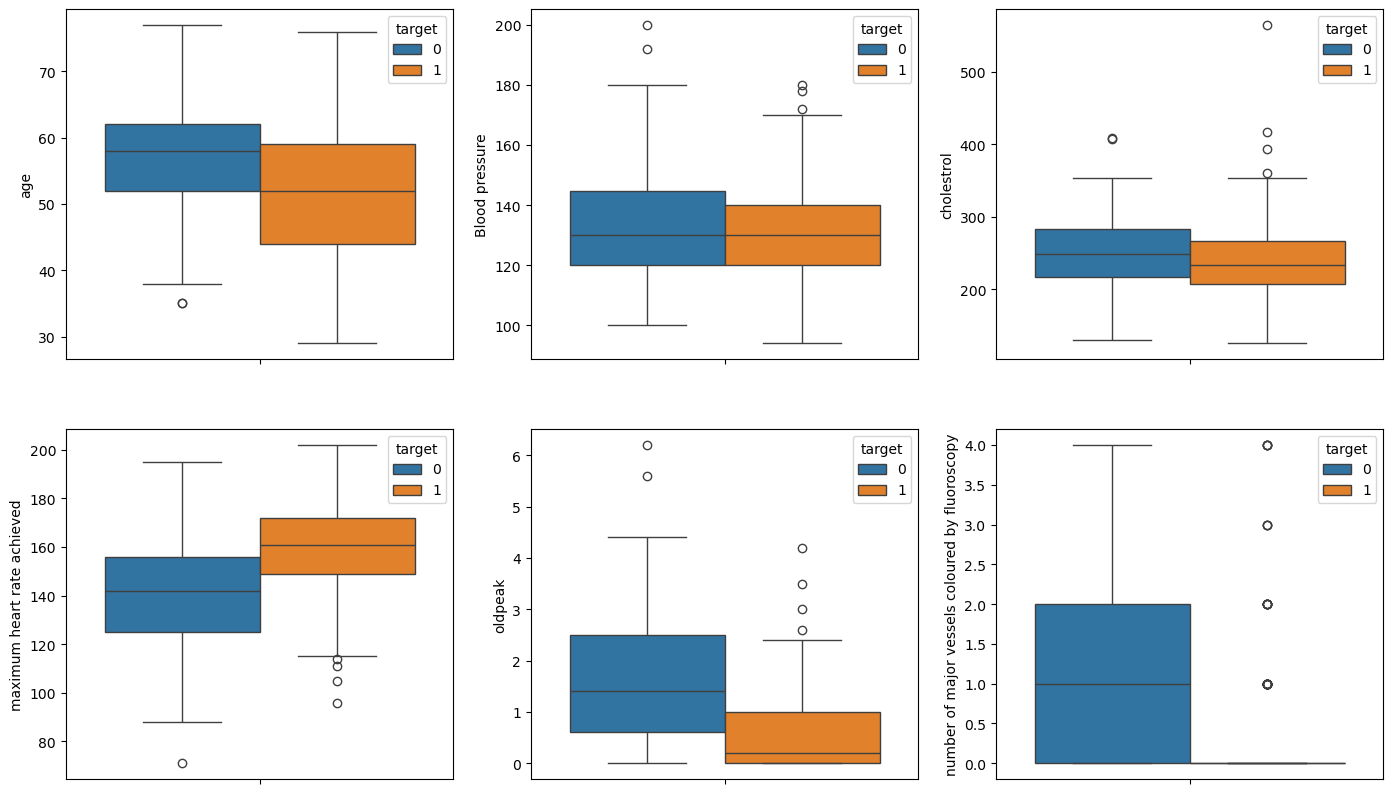

In [19]:
# Distribution of features for each class of target variable

fig = plt.figure(figsize=(17,10))

c = ['age','Blood pressure','cholestrol','maximum heart rate achieved','oldpeak','number of major vessels coloured by fluoroscopy']

x = [231, 232, 233, 234, 235, 236]

for i in range(len(x)):
    ax= fig.add_subplot(x[i])
    sns.boxplot(data = heart_data,  y=c[i], hue='target', ax=ax)

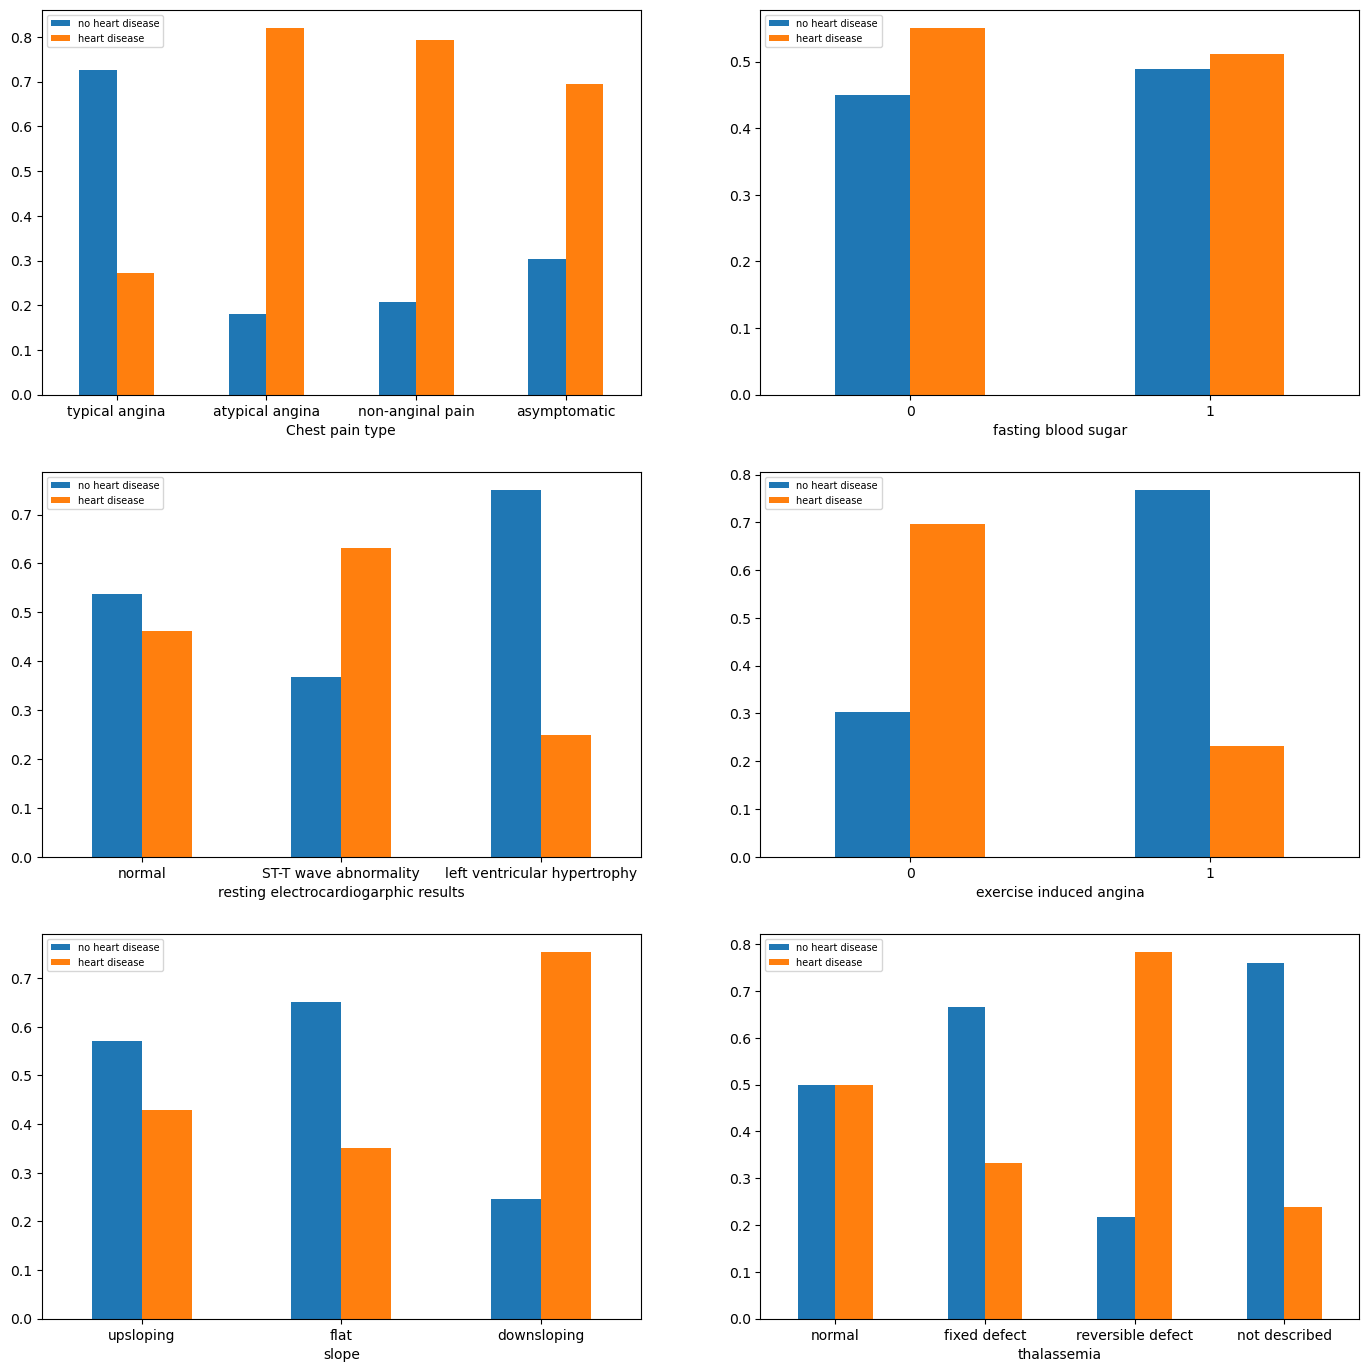

In [20]:
#Crosstab of categorical features and target variable

fig = plt.figure(figsize=(17,17))

x = [321, 322, 323, 324, 325, 326]
c = ['Chest pain type','fasting blood sugar','resting electrocardiogarphic results','exercise induced angina','slope','thalassemia'] 

for i in range(len(x)):
    ax = fig.add_subplot(x[i])
    pd.crosstab(heart_dis_data[c[i]], heart_dis_data['target'], normalize='index').plot(kind='bar', ax=ax)
    plt.legend(['no heart disease','heart disease'], loc='upper left', prop = {'size':7})
    plt.xticks(rotation='horizontal')

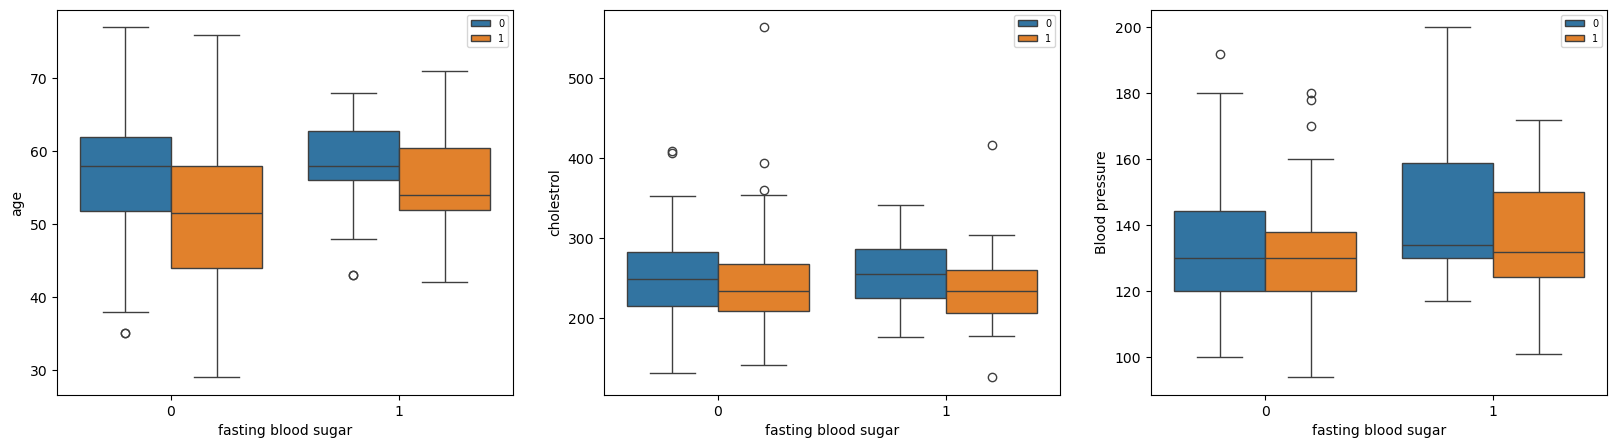

In [25]:
# Distribution of quantitative variables against blood sugar for each class of target variable

fig = plt.figure(figsize=(20,5))

ax1 = fig.add_subplot(131)
sns.boxplot(data = heart_dis_data,  x = heart_dis_data['fasting blood sugar'], y=heart_dis_data['age'], hue='target', ax=ax1)
plt.legend(loc='upper right', prop={'size':7})

ax2 = fig.add_subplot(132)
sns.boxplot(data = heart_dis_data,  x = heart_dis_data['fasting blood sugar'], y=heart_dis_data['cholestrol'], hue='target', ax=ax2)
plt.legend(loc='upper right', prop={'size':7})

ax3 = fig.add_subplot(133)
sns.boxplot(data = heart_dis_data,  x = heart_dis_data['fasting blood sugar'], y=heart_dis_data['Blood pressure'], hue='target', ax=ax3)
plt.legend(loc='upper right', prop={'size':7})

In [26]:
# Normalisation of quantitative features

In [27]:
scale = MinMaxScaler()
features = ['age','Blood pressure','cholestrol','maximum heart rate achieved','oldpeak','number of major vessels coloured by fluoroscopy']
for f in features:
    heart_data[f] = scale.fit_transform(X=np.array(heart_data[f]).reshape(-1,1))

In [28]:
heart_num_data = heart_data[['age','Blood pressure','maximum heart rate achieved','oldpeak','cholestrol','number of major vessels coloured by fluoroscopy']]

<Axes: >

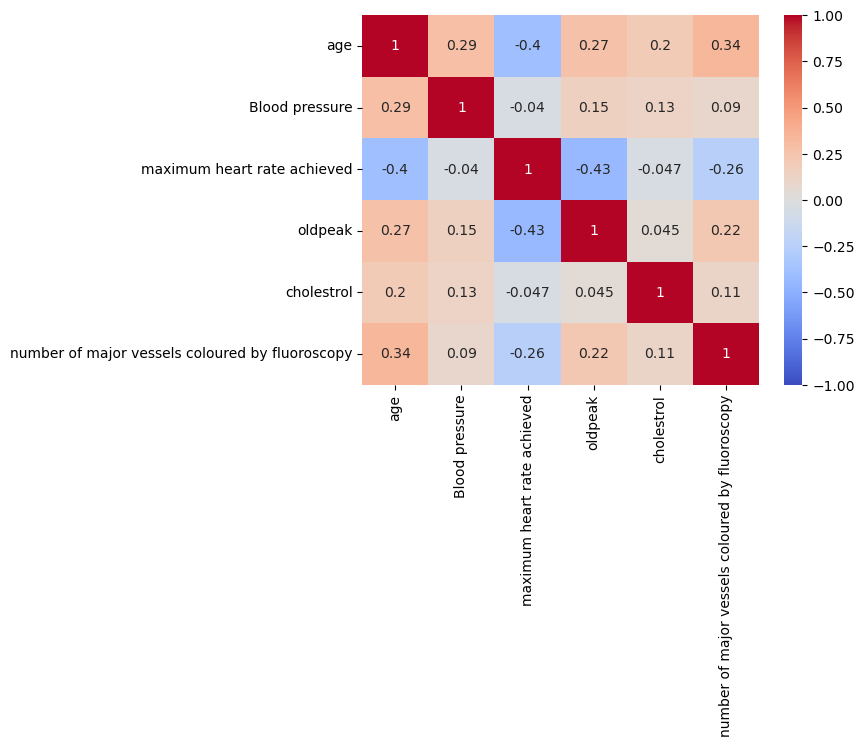

In [38]:
# Correlation matrix 

sns.heatmap(heart_num_data.corr(method='spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

<Axes: xlabel='slope,thalassemia,exercise induced angina'>

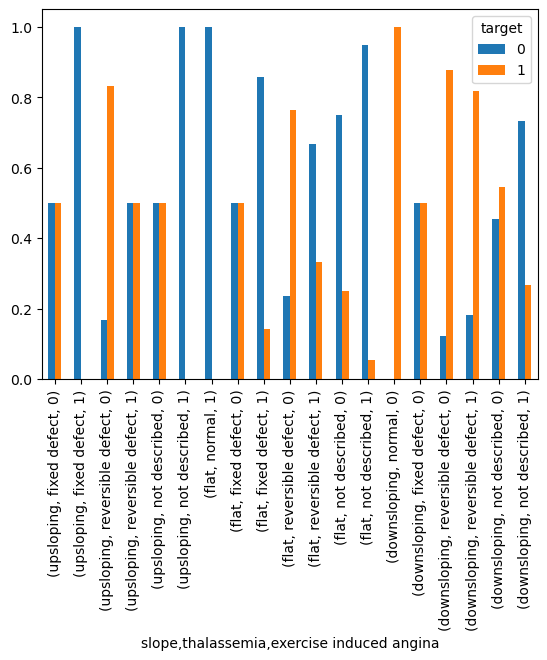

In [41]:
pd.crosstab(index = [heart_dis_data['slope'],heart_dis_data['thalassemia'], heart_dis_data['exercise induced angina']], columns = heart_dis_data['target'], normalize='index').plot(kind='bar')

In [42]:
# Final pre-processed data

heart_data.head()

,age,sex (male = 1),Blood pressure,cholestrol,blood sugar (high = 1),maximum heart rate achieved,exercise induced angina,oldpeak,number of major vessels coloured by fluoroscopy,target,...,ST-T wave abnormality,left ventricular hypertrophy,normal,downsloping,flat,upsloping,fixed defect,normal,not described,reversible defect
0,0.708333,1,0.481132,0.244292,1,0.603053,0,0.370968,0.0,1,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.166667,1,0.339623,0.283105,0,0.885496,0,0.564516,0.0,1,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.250000,0,0.339623,0.178082,0,0.770992,0,0.225806,0.0,1,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.562500,1,0.245283,0.251142,0,0.816794,0,0.129032,0.0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.583333,0,0.245283,0.520548,0,0.702290,1,0.096774,0.0,1,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [43]:
# Selection of the most important features

selected_data = heart_data[['typical angina','reversible defect','number of major vessels coloured by fluoroscopy','oldpeak','maximum heart rate achieved','non-anginal pain','atypical angina',
'asymptomatic','left ventricular hypertrophy','exercise induced angina','downsloping','not described', 'flat','upsloping','fixed defect','ST-T wave abnormality']]

In [45]:
# changing data type of categorical features from float to category

data_col = selected_data.drop(['number of major vessels coloured by fluoroscopy','oldpeak','maximum heart rate achieved'], axis=1).columns

for col in data_col:
    selected_data.loc[:,col] = selected_data.loc[:,col].astype('int')

for col in data_col:
    selected_data.loc[:,col] = selected_data.loc[:,col].astype('category')

In [46]:
selected_data.dtypes

typical angina                                     category
reversible defect                                  category
number of major vessels coloured by fluoroscopy     float64
oldpeak                                             float64
maximum heart rate achieved                         float64
non-anginal pain                                   category
atypical angina                                    category
asymptomatic                                       category
left ventricular hypertrophy                       category
exercise induced angina                            category
downsloping                                        category
not described                                      category
flat                                               category
upsloping                                          category
fixed defect                                       category
ST-T wave abnormality                              category
dtype: object

In [409]:
# Model development
# Splitting the data

x_train, x_test, y_train, y_test = train_test_split(selected_data, heart_data['target'], test_size=0.2, stratify=heart_data['target'], random_state=32)

In [411]:
# Logistic regression
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [413]:
# Hyper parameter tuning 

param = {'C':[0.001,0.01,0.1,10,100], 'l1_ratio':[0.1,0.3,0.5,0.9], 'max_iter':[50,100,200], 'class_weight':['balanced',None]}
logr = LogisticRegression(penalty='elasticnet',verbose=1, solver='saga')
gd_lreg = GridSearchCV(estimator=logr, param_grid=param, verbose=1, cv=stratified_kfold, scoring='f1', n_jobs=4)

In [415]:
gd_lreg.fit(x_train,y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
convergence after 17 epochs took 0 seconds


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(penalty='elasticnet', solver='saga',
                                          verbose=1),
             n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 10, 100],
                         'class_weight': ['balanced', None],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.9],
                         'max_iter': [50, 100, 200]},
             scoring='f1', verbose=1)

In [417]:
gd_lreg.best_params_

{'C': 0.1, 'class_weight': None, 'l1_ratio': 0.3, 'max_iter': 50}

In [419]:
# SMOTE learning for handling imbalanced data in logistic regression

smort = SMOTENC(categorical_features='auto', random_state=32)
x_train_res, y_train_res = smort.fit_resample(x_train, y_train)

In [527]:
log_reg = LogisticRegression(C=0.1, penalty='elasticnet',verbose=1, solver='saga', l1_ratio=0.3, max_iter=50, class_weight=None, random_state=32)
log_reg.fit(x_train_res, y_train_res)

convergence after 18 epochs took 0 seconds


LogisticRegression(C=0.1, l1_ratio=0.3, max_iter=50, penalty='elasticnet',
                   random_state=32, solver='saga', verbose=1)

In [529]:
x_train_pred = log_reg.predict(x_train)
x_test_pred = log_reg.predict(x_test)

In [531]:
print('classification report of train data is')
print(classification_report(y_train, x_train_pred))
print('classification report of test data is')
print(classification_report(y_test, x_test_pred))

classification report of train data is
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       110
           1       0.86      0.81      0.84       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242

classification report of test data is
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        28
           1       0.84      0.82      0.83        33

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



In [533]:
log_reg_acc_train = round(accuracy_score(y_train, x_train_pred),2)
log_reg_acc_test = round(accuracy_score(y_test, x_test_pred),2)

print(accuracy_score(y_train, x_train_pred))
print(accuracy_score(y_test, x_test_pred))

0.8264462809917356
0.819672131147541


In [535]:
fprate_tr_log, tprate_tr_log, thresholds = roc_curve(y_train, x_train_pred)
roc_auc_train_log = auc(fprate_tr_log, tprate_tr_log)

fprate_test_log, tprate_test_log, thresholds = roc_curve(y_test, x_test_pred)
roc_auc_test_log = auc(fprate_test_log, tprate_test_log)

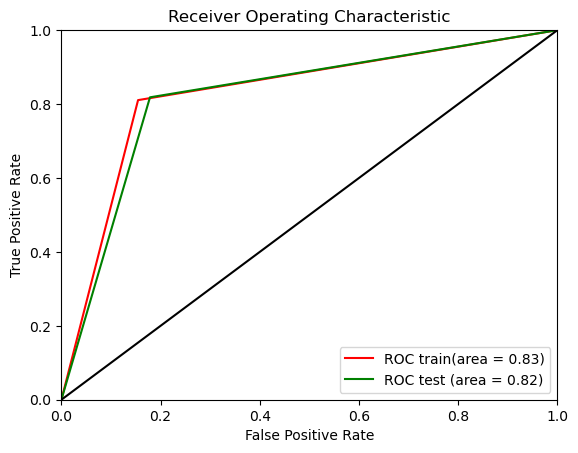

In [539]:
plt.figure()

plt.plot(fprate_tr_log, tprate_tr_log, color='red', label='ROC train(area = %0.2f)' % roc_auc_train_log)
plt.plot(fprate_test_log, tprate_test_log, color='green', label='ROC test (area = %0.2f)' % roc_auc_test_log)

plt.plot([0, 1], [0, 1], color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

In [541]:
#Decision tree classifier

In [445]:
dec_tree = DecisionTreeClassifier(random_state=40)
params = {'criterion':['gini', 'entropy', 'log_loss'], 'max_depth':[2,4,6,8,10,20], 'min_samples_split':[2,4,5,6,7], 'max_features':[10,15,20,23], 'min_samples_leaf':[2,5,10,15], 'class_weight':['balanced',None]}
gd_dec = GridSearchCV(estimator=dec_tree, param_grid=params, verbose=1, cv=stratified_kfold, scoring='f1', n_jobs=4)

In [447]:
gd_dec.fit(x_train,y_train)

Fitting 3 folds for each of 2880 candidates, totalling 8640 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=40), n_jobs=4,
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8, 10, 20],
                         'max_features': [10, 15, 20, 23],
                         'min_samples_leaf': [2, 5, 10, 15],
                         'min_samples_split': [2, 4, 5, 6, 7]},
             scoring='f1', verbose=1)

In [449]:
gd_dec.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 15,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [451]:
dectree = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=15, min_samples_split=2, min_samples_leaf=2, class_weight='balanced', random_state=32)
dectree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, max_features=15,
                       min_samples_leaf=2, random_state=32)

In [323]:
#!pip install graphviz

In [453]:
x_train_pred = dectree.predict(x_train)
x_test_pred = dectree.predict(x_test)

In [455]:
print('classification report of train data is')
print(classification_report(y_train, x_train_pred))
print('classification report of test data is')
print(classification_report(y_test, x_test_pred))

classification report of train data is
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       110
           1       0.90      0.86      0.88       132

    accuracy                           0.87       242
   macro avg       0.87      0.87      0.87       242
weighted avg       0.87      0.87      0.87       242

classification report of test data is
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.77      0.82      0.79        33

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61



In [457]:
dec_acc_train = round(accuracy_score(y_train, x_train_pred),2)
dec_acc_test = round(accuracy_score(y_test, x_test_pred),2)

print(accuracy_score(y_train, x_train_pred))
print(accuracy_score(y_test, x_test_pred))

0.871900826446281
0.7704918032786885


In [459]:
fprate_tr_dec, tprate_tr_dec, thresholds = roc_curve(y_train, x_train_pred)
roc_auc_train_dec = auc(fprate_tr_dec, tprate_tr_dec)

fprate_test_dec, tprate_test_dec, thresholds = roc_curve(y_test, x_test_pred)
roc_auc_test_dec = auc(fprate_test_dec, tprate_test_dec)

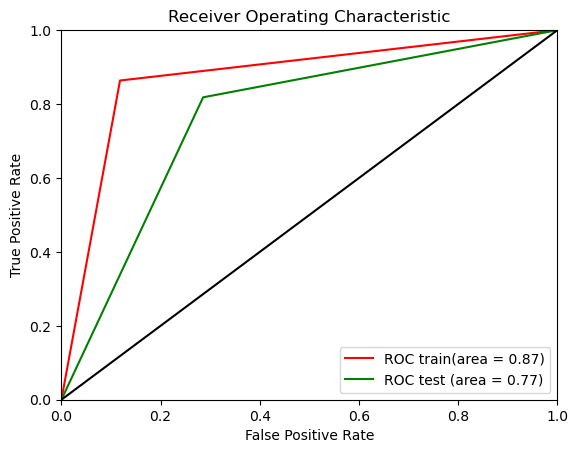

In [461]:
plt.figure()

plt.plot(fprate_tr_dec, tprate_tr_dec, color='red', label='ROC train(area = %0.2f)' % roc_auc_train_dec)
plt.plot(fprate_test_dec, tprate_test_dec, color='green', label='ROC test (area = %0.2f)' % roc_auc_test_dec)

plt.plot([0, 1], [0, 1], color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

In [225]:
#Random forest classifier

In [463]:
ran_for = RandomForestClassifier(verbose=1, random_state=32)
params = {'n_estimators':[50,100,200], 'criterion':['gini','entropy','log_loss'], 'max_depth':[2,3,4,5,6,8], 'min_samples_split':[2,3,5,6,7], 'max_features':[8,10,15,23], 'class_weight':['balanced','balanced_subsample']} 
gd_ran = GridSearchCV(estimator=ran_for, param_grid=params, n_jobs=4, scoring='f1', cv=stratified_kfold, verbose=1)

In [465]:
gd_ran.fit(x_train,y_train)

Fitting 3 folds for each of 2160 candidates, totalling 6480 fits


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=32, verbose=1),
             n_jobs=4,
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 8],
                         'max_features': [8, 10, 15, 23],
                         'min_samples_split': [2, 3, 5, 6, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='f1', verbose=1)

In [467]:
gd_ran.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 8,
 'max_features': 10,
 'min_samples_split': 2,
 'n_estimators': 50}

In [469]:
ranfor = RandomForestClassifier(criterion='gini', max_depth=8, max_features=10, min_samples_split=2, n_estimators=50, class_weight='balanced', verbose=1, random_state=32)
ranfor.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestClassifier(class_weight='balanced', max_depth=8, max_features=10,
                       n_estimators=50, random_state=32, verbose=1)

In [471]:
x_train_pred = ranfor.predict(x_train)
x_test_pred = ranfor.predict(x_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [473]:
print('classification report of train data is')
print(classification_report(y_train, x_train_pred))
print('classification report of test data is')
print(classification_report(y_test, x_test_pred))

classification report of train data is
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       110
           1       0.99      1.00      1.00       132

    accuracy                           1.00       242
   macro avg       1.00      1.00      1.00       242
weighted avg       1.00      1.00      1.00       242

classification report of test data is
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        28
           1       0.82      0.82      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



In [475]:
ran_acc_train = round(accuracy_score(y_train, x_train_pred),2)
ran_acc_test = round(accuracy_score(y_test, x_test_pred),2)

print(accuracy_score(y_train, x_train_pred))
print(accuracy_score(y_test, x_test_pred))

0.9958677685950413
0.8032786885245902


In [477]:
fprate_tr_ran, tprate_tr_ran, thresholds = roc_curve(y_train, x_train_pred)
roc_auc_train_ran = auc(fprate_tr_ran, tprate_tr_ran)

fprate_test_ran, tprate_test_ran, thresholds = roc_curve(y_test, x_test_pred)
roc_auc_test_ran = auc(fprate_test_ran, tprate_test_ran)

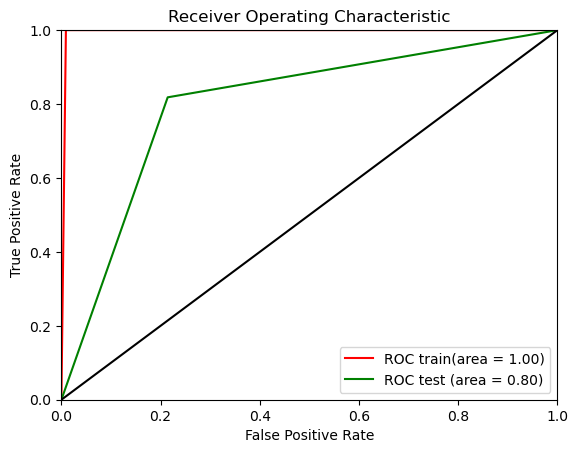

In [479]:
plt.figure()

plt.plot(fprate_tr_ran, tprate_tr_ran, color='red', label='ROC train(area = %0.2f)' % roc_auc_train_ran)
plt.plot(fprate_test_ran, tprate_test_ran, color='green', label='ROC test (area = %0.2f)' % roc_auc_test_ran)

plt.plot([0, 1], [0, 1], color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

In [209]:
#Support vector Machines

In [481]:
svc = SVC(random_state=32)
params = {'C':[0.001,0.1,1,10,100], 'kernel':['linear','rbf','poly','sigmoid'],'gamma':[0.001,0.1,1,10,100], 'class_weight':['balanced',None]}
svc_gd = GridSearchCV(estimator=svc, param_grid=params, n_jobs=4, scoring='f1', cv=stratified_kfold, verbose=1)

In [483]:
svc_gd.fit(x_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(random_state=32), n_jobs=4,
             param_grid={'C': [0.001, 0.1, 1, 10, 100],
                         'class_weight': ['balanced', None],
                         'gamma': [0.001, 0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             scoring='f1', verbose=1)

In [485]:
svc_gd.best_params_

{'C': 10, 'class_weight': None, 'gamma': 0.001, 'kernel': 'sigmoid'}

In [487]:
svcb = SVC(C=10, class_weight=None, gamma=0.001, kernel='sigmoid', verbose=1)
svcb.fit(x_train,y_train)

[LibSVM]

SVC(C=10, gamma=0.001, kernel='sigmoid', verbose=1)

In [489]:
x_train_pred = svcb.predict(x_train)
x_test_pred = svcb.predict(x_test)

In [491]:
print('classification report of train data is')
print(classification_report(y_train, x_train_pred))
print('classification report of test data is')
print(classification_report(y_test, x_test_pred))

classification report of train data is
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       110
           1       0.85      0.85      0.85       132

    accuracy                           0.83       242
   macro avg       0.83      0.83      0.83       242
weighted avg       0.83      0.83      0.83       242

classification report of test data is
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        28
           1       0.85      0.85      0.85        33

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [493]:
svc_acc_train = round(accuracy_score(y_train, x_train_pred),2)
svc_acc_test = round(accuracy_score(y_test, x_test_pred),2)

print(accuracy_score(y_train, x_train_pred))
print(accuracy_score(y_test, x_test_pred))

0.8347107438016529
0.8360655737704918


In [495]:
# Plotting roc auc curve

fprate_tr_svc, tprate_tr_svc, thresholds = roc_curve(y_train, x_train_pred)
roc_auc_train_svc = auc(fprate_tr_svc, tprate_tr_svc)

fprate_test_svc, tprate_test_svc, thresholds = roc_curve(y_test, x_test_pred)
roc_auc_test_svc = auc(fprate_test_svc, tprate_test_svc)

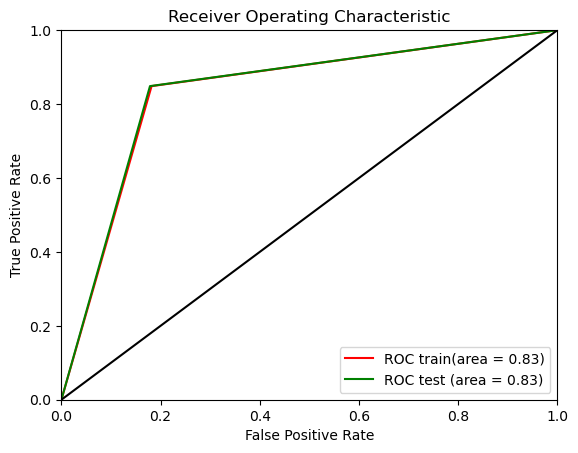

In [497]:
plt.figure()

plt.plot(fprate_tr_svc, tprate_tr_svc, color='red', label='ROC train(area = %0.2f)' % roc_auc_train_svc)
plt.plot(fprate_test_svc, tprate_test_svc, color='green', label='ROC test (area = %0.2f)' % roc_auc_test_svc)

plt.plot([0, 1], [0, 1], color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

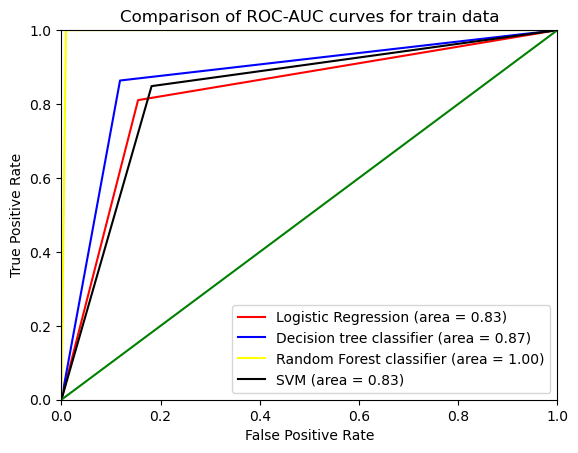

In [543]:
# Model comparison (train data)

plt.figure()

plt.plot(fprate_tr_log, tprate_tr_log, color='red', label='Logistic Regression (area = %0.2f)' % roc_auc_train_log)
plt.plot(fprate_tr_dec, tprate_tr_dec, color='blue', label='Decision tree classifier (area = %0.2f)' % roc_auc_train_dec)
plt.plot(fprate_tr_ran, tprate_tr_ran, color='yellow', label='Random Forest classifier (area = %0.2f)' % roc_auc_train_ran)
plt.plot(fprate_tr_svc, tprate_tr_svc, color='black', label='SVM (area = %0.2f)' % roc_auc_train_svc)

plt.plot([0, 1], [0, 1], color='green')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC-AUC curves for train data')

plt.legend(loc='lower right')


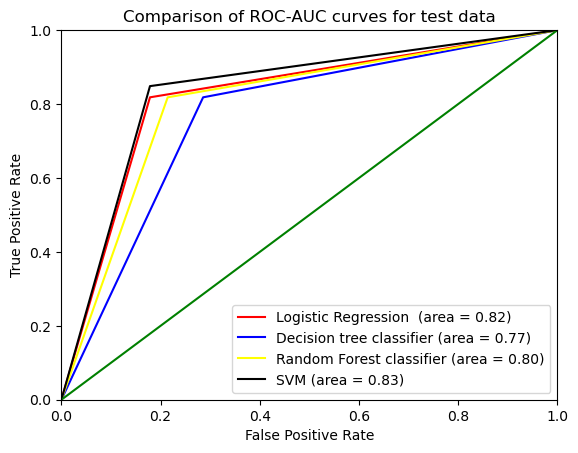

In [545]:
# Model comparison (test data)

plt.figure()


plt.plot(fprate_test_log, tprate_test_log, color='red', label='Logistic Regression  (area = %0.2f)' % roc_auc_test_log)
plt.plot(fprate_test_dec, tprate_test_dec, color='blue', label='Decision tree classifier (area = %0.2f)' % roc_auc_test_dec)
plt.plot(fprate_test_ran, tprate_test_ran, color='yellow', label='Random Forest classifier (area = %0.2f)' % roc_auc_test_ran)
plt.plot(fprate_test_svc, tprate_test_svc, color='black', label='SVM (area = %0.2f)' % roc_auc_test_svc)

plt.plot([0, 1], [0, 1], color='green')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC-AUC curves for test data')

plt.legend(loc='lower right')

In [501]:
target_values = heart_data['target'].value_counts()/len(heart_data['target'])
scale_pos_wgt = target_values[0]/target_values[1]

In [503]:
# XG BOOST classifier

xgbclas = XGBClassifier(objective='binary:logistic', tree_method='auto', eval_metric='logloss', scale_pos_weight=scale_pos_wgt , enable_categorical=True)

param = {'max_depth' : [1,3,4,5], 'subsample':[0.1,0.4,0.7,1], 'colsample_bytree':[0.4,0.6,0.7,1], 'learning_rate':[0.01,0.1,0.3,0.6],'n_estimators':[50,100,200],
        'reg_alpha': [0, 0.001, 0.01, 0.1, 1], 'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10]}

grid_cv = GridSearchCV(estimator=xgbclas, param_grid=param, n_jobs=4, scoring='f1', verbose=1, cv=stratified_kfold)

In [505]:
grid_cv.fit(x_train, y_train)

Fitting 3 folds for each of 23040 candidates, totalling 69120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance...
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.4, 0.6, 0.7, 1],
                         'learning_rate': [0.01, 0.1, 0.3, 0.6],
                         'max_depth': [1, 3, 4, 5],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0, 0.001, 0.01, 0.1, 1],
                         'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10],
                         'subsample': [0.1, 0.4, 0.7, 1]},
             scoring='f1', verbose=1)

In [399]:
grid_cv.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.6,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0.01,
 'reg_lambda': 10,
 'subsample': 0.4}

In [507]:
xgb_cl = XGBClassifier(objective='binary:logistic', tree_method='auto', eval_metric='logloss', enable_categorical=True, colsample_bytree=1, 
                       learning_rate=0.6, max_depth=3, n_estimators=100, subsample=0.4, reg_alpha=0.01, reg_lambda=10)

xgb_cl.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.6, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [509]:
x_train_pred = xgb_cl.predict(x_train)
x_test_pred = xgb_cl.predict(x_test)

In [511]:
print('classification report of train data is')
print(classification_report(y_train, x_train_pred))
print('classification report of test data is')
print(classification_report(y_test, x_test_pred))

classification report of train data is
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       110
           1       0.92      0.95      0.93       132

    accuracy                           0.93       242
   macro avg       0.93      0.92      0.92       242
weighted avg       0.93      0.93      0.93       242

classification report of test data is
              precision    recall  f1-score   support

           0       0.81      0.93      0.87        28
           1       0.93      0.82      0.87        33

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



In [513]:
xg_acc_train = round(accuracy_score(y_train, x_train_pred),2)
xg_acc_test = round(accuracy_score(y_test, x_test_pred),2)

print(accuracy_score(y_train, x_train_pred))
print(accuracy_score(y_test, x_test_pred))

0.9256198347107438
0.8688524590163934


In [515]:
# plotting roc auc curve

fprate_tr_xgb, tprate_tr_xgb, thresholds = roc_curve(y_train, x_train_pred)
roc_auc_train_xgb = auc(fprate_tr_xgb, tprate_tr_xgb)

fprate_test_xgb, tprate_test_xgb, thresholds = roc_curve(y_test, x_test_pred)
roc_auc_test_xgb = auc(fprate_test_xgb, tprate_test_xgb)

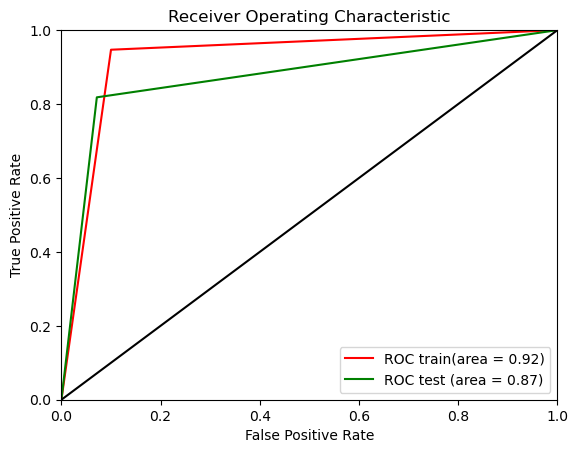

In [517]:
plt.figure()

plt.plot(fprate_tr_xgb, tprate_tr_xgb, color='red', label='ROC train(area = %0.2f)' % roc_auc_train_xgb)
plt.plot(fprate_test_xgb, tprate_test_xgb, color='green', label='ROC test (area = %0.2f)' % roc_auc_test_xgb)

plt.plot([0, 1], [0, 1], color='black')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

plt.legend(loc='lower right')

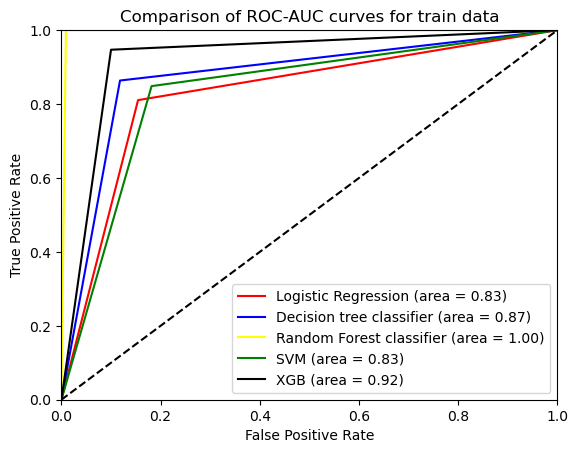

In [547]:
# Model comparison (train data) including XG Boost classifier

plt.figure()


plt.plot(fprate_tr_log, tprate_tr_log, color='red', label='Logistic Regression (area = %0.2f)' % roc_auc_train_log)
plt.plot(fprate_tr_dec, tprate_tr_dec, color='blue', label='Decision tree classifier (area = %0.2f)' % roc_auc_train_dec)
plt.plot(fprate_tr_ran, tprate_tr_ran, color='yellow', label='Random Forest classifier (area = %0.2f)' % roc_auc_train_ran)
plt.plot(fprate_tr_svc, tprate_tr_svc, color='green', label='SVM (area = %0.2f)' % roc_auc_train_svc)
plt.plot(fprate_tr_xgb, tprate_tr_xgb, color='black', label='XGB (area = %0.2f)' % roc_auc_train_xgb)

plt.plot([0, 1], [0, 1], color='black', ls='dashed')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC-AUC curves for train data')

plt.legend(loc='lower right')


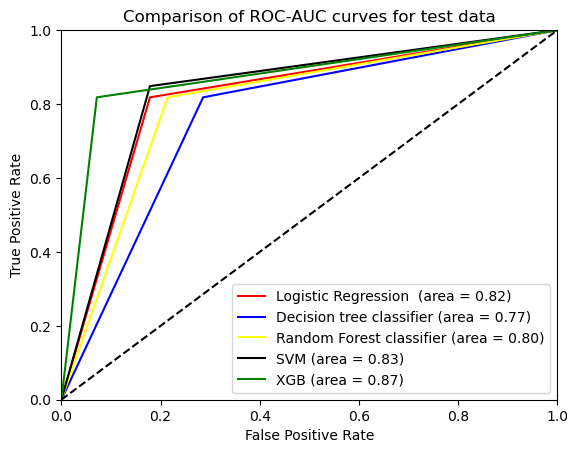

In [549]:
# Model comparison (test data) including XG Boost classifier

plt.figure()


plt.plot(fprate_test_log, tprate_test_log, color='red', label='Logistic Regression  (area = %0.2f)' % roc_auc_test_log)
plt.plot(fprate_test_dec, tprate_test_dec, color='blue', label='Decision tree classifier (area = %0.2f)' % roc_auc_test_dec)
plt.plot(fprate_test_ran, tprate_test_ran, color='yellow', label='Random Forest classifier (area = %0.2f)' % roc_auc_test_ran)
plt.plot(fprate_test_svc, tprate_test_svc, color='black', label='SVM (area = %0.2f)' % roc_auc_test_svc)
plt.plot(fprate_test_xgb, tprate_test_xgb, color='green', label='XGB (area = %0.2f)' % roc_auc_test_xgb)


plt.plot([0, 1], [0, 1], color='black', ls='dashed')

plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC-AUC curves for test data')

plt.legend(loc='lower right')

In [551]:
# Model comparison

models = ['logistic regression', 'decision tree', 'random forest', 'SVC', 'xgboost']
train_accuracies = [log_reg_acc_train, dec_acc_train, ran_acc_train, svc_acc_train, xg_acc_train]
test_accuracies = [log_reg_acc_test, dec_acc_test, ran_acc_test, svc_acc_test, xg_acc_test]

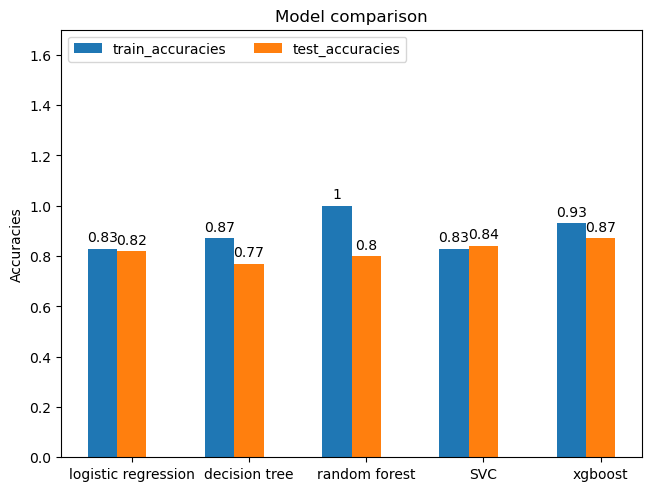

In [553]:
models = ('logistic regression', 'decision tree', 'random forest', 'SVC', 'xgboost')


data_acc = {
    'train_accuracies': (log_reg_acc_train, dec_acc_train, ran_acc_train, svc_acc_train, xg_acc_train),
    'test_accuracies': (log_reg_acc_test, dec_acc_test, ran_acc_test, svc_acc_test, xg_acc_test),
}

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for data, accuracy in data_acc.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, accuracy, width, label=data)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracies')
ax.set_title('Model comparison')
ax.set_xticks(x + width, models)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(0,1.7)

plt.show()

In [555]:
# Model deployment (Logistic Regression model was finally selected for model deployment; model stored as pickle file)

filename = 'C:/Users/61450/Desktop/refonte folder/heart disease prediction/model.pkl'
pickle.dump(xgb_cl, open(filename, 'wb'))